## Computer Vision Coursework Project - SIFT + SVM Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Computer Vision/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Models', 'Personal_Video', 'test_function.ipynb']


The code in the following box was written with the help of the code present in lab 6 [1].

In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

In [4]:
# Make a folder to put the train and test sets into it
!mkdir -p CV2024_CW_Dataset

In [5]:
# Move files to CV2024_CW_Dataset folder
!mv test CV2024_CW_Dataset/
!mv train CV2024_CW_Dataset/

Let's now import all the appropriate libraries to run the coding task.

In [6]:
import cv2
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline

The following is a function used to load images with their respective labels, taken from lab 6 [1] and modified for the relevant data.

In [7]:
def import_selected_data(image_folder, label_folder):
    """Load images and labels from selected directories"""
    # Creates empty lists for both images and labels
    images = []
    labels = []

    # Lists all files in the image folder and filters them to only keep .jpeg files
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith('.jpeg')]

    # Loops over every image file + builds full paths to both images and labels
    for img_file in image_files:
      img_path = os.path.join(image_folder, img_file)
      label_path = os.path.join(label_folder, img_file.replace('.jpeg','.txt'))

      # Loads the image + appends it to the images list
      img = io.imread(img_path)
      images.append(img)

      # Loads the label + converts it to an integer + appends it to the labels list
      with open (label_path, 'r') as f:
        label = int(f.readline().strip())
      labels.append(label)

    return images, labels

In [8]:
X_train, y_train = import_selected_data('CV2024_CW_Dataset/train/images', 'CV2024_CW_Dataset/train/labels')
X_test, y_test = import_selected_data('CV2024_CW_Dataset/test/images', 'CV2024_CW_Dataset/test/labels')

In [9]:
# Let's check the data distribution of labels
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 1940, 0: 376, 2: 78})
Counter({1: 388, 0: 51, 2: 19})


Now, as it can be seen the labels between each class are quite imbalanced, let's try and fix this by using the imbalanced learn package, with the help of the code and explanation provided in [2].

In [10]:
# Let's first install the imbalanced-learn library
!pip install -U imbalanced-learn

In [11]:
import imblearn
print(imblearn.__version__)

0.13.0


In [12]:
print(X_train[0].shape)
print(X_train[5].shape)
print(X_train[10].shape)

(37, 30, 3)
(23, 16, 3)
(29, 29, 3)


As shown by the above cell, the images in the training folder have different sizes, so before balancing the dataset, let's resize AND flatten all images (after resampling we will convert them back to a common image shape - e.g. (64,64,3)).

In [13]:
# Import function to resize images
from skimage.transform import resize

# Set a standard image size
target_size = (64, 64)

# Overwrite with resized images
X_train = [resize(img, target_size + (3,), anti_aliasing=True) for img in X_train]

# Flatten each image and put them in array format
X_train = [img.flatten() for img in X_train]
X_train = np.array(X_train)

Resample images by oversampling classes 0 and 2 and undersampling class 1 - code taken from [2].

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print("Original Sample:",Counter(y_train))

# Oversampling the two minority classes
over = RandomOverSampler(sampling_strategy = {0:1000, 2:1000})
X_train, y_train = over.fit_resample(X_train,y_train)
print("After Over Sampling:", Counter(y_train))

# Undersampling the majority class
under = RandomUnderSampler(sampling_strategy = {0:1000, 1:1000})
X_train, y_train = under.fit_resample(X_train, y_train)
print("After Under Sampling:", Counter(y_train))

Original Sample: Counter({1: 1940, 0: 376, 2: 78})
After Over Sampling: Counter({1: 1940, 0: 1000, 2: 1000})
After Under Sampling: Counter({0: 1000, 1: 1000, 2: 1000})


Convert images back to a common shape and size.

In [15]:
X_train = X_train.reshape(-1, 64, 64, 3)

Since we now have all images in the training set of the same size and shape, let's make it fair and apply it also to the test set

In [16]:
# Set a standard image size
target_size = (64, 64)

# Overwrite with resized images
X_test = [resize(img, target_size + (3,), anti_aliasing=True) for img in X_test]

print("Image train size:",X_train[0].shape)
print("Image test size:",X_test[0].shape)

Image train size: (64, 64, 3)
Image test size: (64, 64, 3)


## SIFT + SVM

The below code is taken from lab 6 [1].

What the SIFT detector will do is, detect interest points and extract feature descriptors. Additionally, it will display the first 5 images.

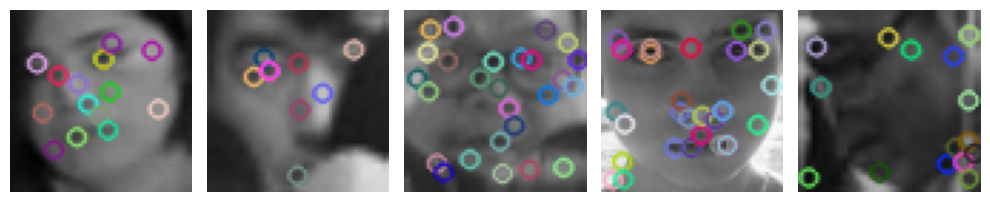

In [17]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 5, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 5 images
    if i<5:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

The next steps will be to cluster the descriptors to create codewords, by using k-means, and to convert descriptors into histograms of codewords for each image.

Also this code was partly taken from lab 6 [1].

In order to find the best hyper-parameters to do the above, first a grid search to tune the values of k and the batch_size will be perfomed on a standard radial-basis-function kernel and subsequently a grid search on the kernel values will be conducted.

In [18]:
print(len(np.unique(y_train)))
print(des_array.shape[0])

3
64616


In [19]:
from sklearn.model_selection import cross_val_score

# Grid of parameters to loop
k_values = [15, 30, 60]
batch_sizes = [des_array.shape[0]//8, des_array.shape[0]//4, des_array.shape[0]//2]

best_score = 0
best_config = {}

# Looping over k_values and mini_batch_sizes
for k in k_values:
  for batch_size in batch_sizes:
    # Clustering with MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

    # Converting descriptors to histograms
    hist_list = []
    for des in des_list:
      hist = np.zeros(k)
      idx = kmeans.predict(des)
      for j in idx:
        hist[j] = hist[j] + (1 / len(des))
      hist_list.append(hist)

    # Stacking histograms for classification
    hist_array = np.vstack(hist_list)

    classifier = svm.SVC(kernel='rbf')
    scores = cross_val_score(classifier, hist_array, y_train_list, cv=5)
    mean_score = scores.mean()

    print(f"k={k}, batch_size={batch_size} → Accuracy: {mean_score:.4f}")

    # Tracking the best combination between k and batch_size values
    if mean_score > best_score:
            best_score = mean_score
            best_config = {'k': k, 'batch_size': batch_size}

print("Best config:", best_config)
print("Best accuracy:", best_score)

k=15, batch_size=8077 → Accuracy: 0.7796
k=15, batch_size=16154 → Accuracy: 0.7612
k=15, batch_size=32308 → Accuracy: 0.7475
k=30, batch_size=8077 → Accuracy: 0.8370
k=30, batch_size=16154 → Accuracy: 0.8397
k=30, batch_size=32308 → Accuracy: 0.8323
k=60, batch_size=8077 → Accuracy: 0.8854
k=60, batch_size=16154 → Accuracy: 0.8681
k=60, batch_size=32308 → Accuracy: 0.8624
Best config: {'k': 60, 'batch_size': 8077}
Best accuracy: 0.8854406173053194


Now that we have the optimal k and batch_size values, we can rebuild the histograms with these and then perform a grid search for the SVC kernel parameters.

In [20]:
k = 60
batch_size = 8077

kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

# Building histograms
hist_list = []
for des in des_list:
    hist = np.zeros(k)
    idx = kmeans.predict(des)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

In [21]:
# import GridSearchCV fucntion
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid.fit(hist_array, y_train_list)

# Show best configuration
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Final classifier
BEST_SIFT_SVM = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8727438707768244


Now that we've found the optimal hyper-parameter values and are done with training part, let's test our model's performance by first detecting interest points, extracting features and finally associating histograms of codewords from each image to the test set (code and explanation taken from [1]).

In [22]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [23]:
# Predicting classes of each test image
y_pred = BEST_SIFT_SVM.predict(hist_array).tolist()

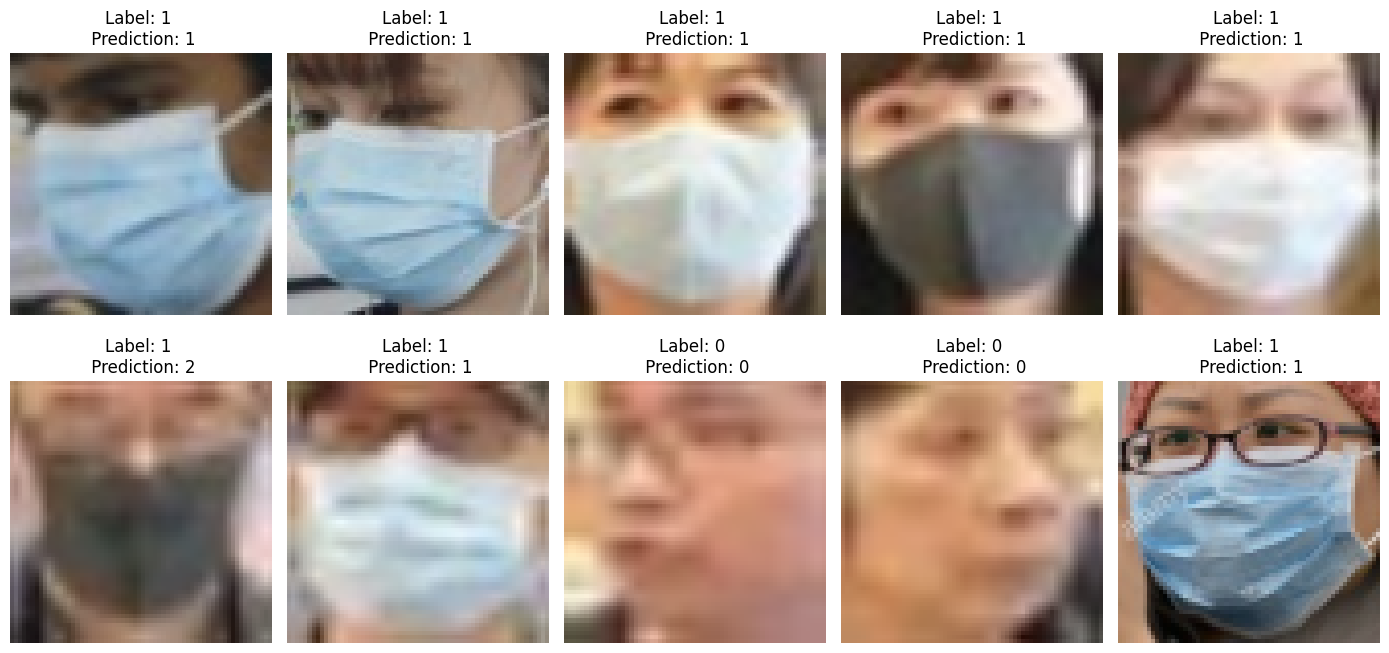

In [24]:
# Comparing predicted vs true labels
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [25]:
# Analysis of model's performance
print(f"""Classification report for classifier {BEST_SIFT_SVM}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC(C=100, gamma=1):
                    precision    recall  f1-score   support

           0       0.38      0.65      0.47        51
           1       0.92      0.80      0.85       387
           2       0.09      0.16      0.11        19

    accuracy                           0.75       457
   macro avg       0.46      0.53      0.48       457
weighted avg       0.83      0.75      0.78       457




Let's construct a confusion matrix and display it, along with all its relevant evaluation metrics.

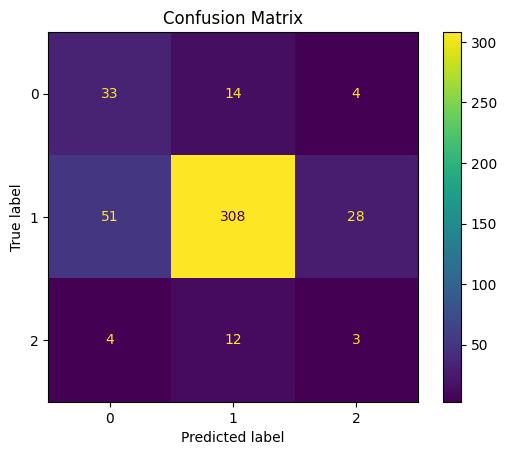

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.title("Confusion Matrix")
plt.show()

In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7527
Precision: 0.8263
Recall:    0.7527
F1 Score:  0.7811


## References

[1] G. Tarroni, *Lab_06_Solved,* unpublished lab tutorial, Dept. of Science and Technology, City St. George's, University of London, 2025.

[2] J. Brownlee, "Random Oversampling and Undersampling for Imbalanced Classification," Machine Learning Mastery. [Online]. Available at: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/. [Accessed: Apr. 21, 2025].

Let's save the best model.

In [29]:
from joblib import dump

modelPath = "/content/drive/My Drive/Computer Vision/CW_Folder_PG/Models/BEST_SIFT_SVM.joblib"
dump(BEST_SIFT_SVM, modelPath)

['/content/drive/My Drive/Computer Vision/CW_Folder_PG/Models/BEST_SIFT_SVM.joblib']